# Step4 演習01 ロジスティック回帰からニューラルネットへ
---

Step4では手書き数字の認識(Optical Character Recognition; OCR)を実装します。

まずはロジスティック回帰で実装を行い、モデルやパラメータを変更することによってスコアへどのような影響があるか体験してもらいます。

今回はscikit-learnを利用して実装を行います。

OCRはマルチクラス分類問題ですが、scikit-learnの`LogisticRegression()`を使うとオプションなしで一対多分類器として動いてくれるため、とても簡単にOCRを実装できます。

次に、ニューラルネットワークでロジスティック回帰を実装します。

多層のニューラルネットワークへの学習（ディープラーニング）もパラメータを変えるだけで実現できるので、学習にかかる時間とスコアの違いを身をもって体感してください。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- scikit-learnを使ったロジスティック回帰の実装手順を学ぶ。
- モデルやパラメータを変更することによるスコアへの影響を体験する。
- 手書き数字MNISTを使ったマルチクラス分類を実装する。


## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## 今回使うデータに関して
数字OCRのサンプルデータとしてMNISTが有名です。MNISTは手書き数字の画像のデータセットになっています。機械学習業界の"Hello, world!"ということができるでしょう。これからMNISTとはいったいどういったものなのか使用するデータの性質をみていきましょう。

「0」から「9」までの10種類の数字をこれから判別します。

In [2]:
num_labels = 10 #「0」から「9」の数字をこれから判別します。

## MNISTデータのロード
データをロードします。
mldata.orgからMNIST originalデータをダウンロードします。使用している回線によっては時間がかかる場合があります。

一度ダウンロードしたらキャッシュしますので、再度走らせるときはダウンロードの時間がかかりません。

In [3]:
mnist = datasets.fetch_mldata('MNIST original')

今回使用するMNISTの画像の枚数は70000枚、画像データのと特徴は28x28 = 784ピクセルです。

- 画像データの数：70000枚
- 画像データの特徴：28x28 = 784ピクセル

下のセルを実行することで画像データの数を** num_data **に、画像データの特徴を** input_layer_size  ** にそれぞれ格納します。


In [4]:
num_data, input_layer_size = mnist.data.shape #70000枚の28x28=784ピクセルの画像です

In [5]:
print("訓練データ数：{}".format(num_data))
print("訓練データの特徴の数：{}".format(input_layer_size))

訓練データ数：70000
訓練データの特徴の数：784


## データのシャッフル
MNIST originalデータをシャッフルしてその冒頭3000サンプルだけ訓練データとして利用することにします。

今回使用するMNISTデータのサンプル数は70000です。この全てを訓練データとして使ってしまうと、学習に使用しなかったデータに対しても正しく予測してくれるのか判断する方法がなくなってしまいます。試作段階では全てのデータを学習に用いてはいけません。（詳しくはStep5で学びます）

また今回10分の1未満のデータせセットしか学習に使わないのは別の理由もあります。マシンスペックの関係で、膨大なデータを用いると学習がなかなか終わらないためです。今回は3000サンプルのみを使用します。

ここで3000サンプルをピックアップする前にデータをシャッフルするのは何故でしょうか。例えば、データがラベル(y)に対してソートされていたとします。すると、そのまま冒頭3000サンプルを取ってしまうと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。ぱっと見で分からないような規則でソートされている可能性もあるので、一見バラバラに見えても必ず最初にシャッフルしましょう。

下のセルを実行すると3000サンプルをランダムにシャッフルしたデータを、** X ** と ** y ** にそれぞれ格納してくれます。

In [6]:
shuffle_idx = np.random.permutation(num_data)
X = mnist.data[shuffle_idx[:3000]]   # ランダム化された画像データ3000枚
y = mnist.target[shuffle_idx[:3000]] # 各画像（3000枚）に書かれている数字（「正しい答え」）

データのシャッフルはscikit-learnのtrain_test_splitを使うこともできます。これは訓練用のデータとテスト用のデータを分けてくれるので便利です。習熟したらscikit-learnチュートリアルを読んでこれを使いましょう。

参考：
[scikit-learnチュートリアル sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

訓練例の数(3000個)は`m`、特徴の数(784ピクセル)は`n`に格納します。

In [7]:
X.shape

(3000, 784)

In [8]:
m, n = X.shape #訓練例の数はm, 特徴の数はn

In [9]:
print("訓練例の数：{}".format(m))
print("特徴の数：{}".format(n))

訓練例の数：3000
特徴の数：784


## データの視覚化
使用するデータの準備ができました。ここではランダムに並べた最初の画像を表示させてみます。

配列`X`には3000枚の画像データ(pixel)が、一列に並んで入っています。（`X`の`shape`は`(3000, 784)`）

この画像を表示させるには、一列に並んでしまっている`3000`枚の画像データをそれぞれ２次元`(28, 28)`に戻す必要があります。それには`reshape`を使います。

下の画像は一枚の数字データに対してreshapeを行なったイメージ図です。

<div align="center"  style="width:70%">
<img src="./dataStep4/img_reshape.png"></div>

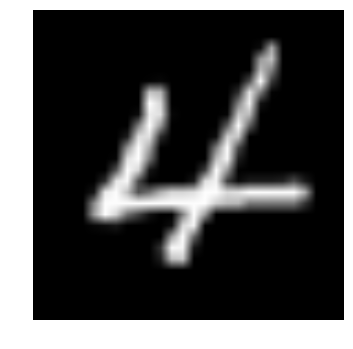

数字 4


In [10]:
X_reshaped = X.reshape((3000, 28, 28))

plt.imshow(X_reshaped[0,:,:])
plt.axis("off")
plt.gray()
plt.show()

print("数字 {0:1.0f}".format(y[0]))

一つだけでは見栄えがしないので、100個表示させるプログラムを関数（ `displayData(images)` ）として実装しておきましょう。

In [11]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

これを使って、訓練データから冒頭100個選んで視覚化しましょう。多少表示に時間がかかります。

セルの左、In [何某]のところが＊になっているとき、そのセルは実行中です。

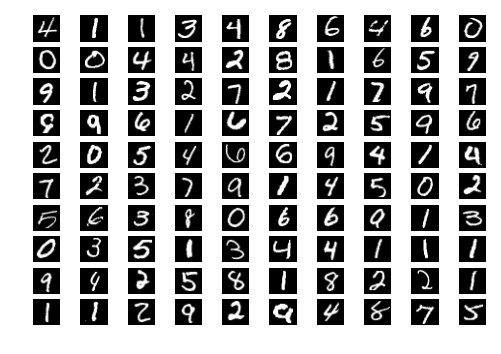

In [13]:
displayData(X[:100, :])

## ロジスティック回帰の実装
まずはオーソドックスにロジスティック回帰を実装してみましょう。Pythonで最も多用される機械学習ライブラリである、Scikit-learnを用います。

以下を実行すると、指定したモデルでの学習が行われます。今回訓練例の数が少ないので比較的学習にかかる時間は短いですが、通常これにはとても時間がかかります。

In [14]:
estimator = LogisticRegression() #ロジスティック回帰を行う仕掛け（インスタンス）を作成。マルチクラス分類問題にも対応。
estimator.fit(X,y) #作った分類器を、ランダムに選んだ3000個のデータXをフィットさせ、学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

ここで`Out`に出てきたものは、** 実際のfit（学習）に使われたオプション **です。`LogisticRegression()`の括弧の中にデフォルトでこれだけのオプションを予めセットしてくれています。実は、** `LogisticRegression()`はとても高機能で、オプションを具体的に指定することでカスタマイズが可能です。**

参考：
[Scikit-learnチュートリアル sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

では、慣れるために少しオプションを付け加えてみましょう。

ここに`C`というオプションが出てきますが、これは正則化パラメータ$\lambda$の逆数だと思ってください。

In [15]:
C = 10 #正則化パラメータλの逆数のようなもの
fit_iter = 50 #勾配法の最大繰返し回数

In [16]:
estimator = LogisticRegression(C=C, max_iter=fit_iter) #オプションを具体的に渡してインスタンスを作成。
estimator.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 訓練例に対するスコア
訓練データに対してどのくらいのスコア（正解率）を出してくれるのか確認しよう

In [17]:
accuracy_train = estimator.score(X, y)
print(accuracy_train * 100,end="")
print("%")

100.0%


**【課題１】** スコアが100.0%になるのはなぜでしょうか。100.0%であることは良いことなのでしょうか。どのようなときに100.0%にならないのかを含めて、考察してください。

In [18]:
#Coursemale-02 Step4 QuestionNumber1 eb6ceea2206d1403291bf6c64ac4ff21
print("この課題の採点は全員正解とします。")

この課題の採点は全員正解とします。


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [19]:
%%bash
./validation_client.py male-02 4 1 Step4_01.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



**答え**

訓練集合に対してフィッティングするということは、訓練集合に対して正解率が高くなるようにパラメータ（ウェイト）を調整することである。そのため訓練集合に対して高いスコアになること自体は自明である。なかでも100.0%と非常に高いスコアとなったのは、訓練集合がパラメータ（ウェイト）の数と比較して少ないこと、正則化パラメータ$\lambda$が小さかった（`C`が大きかった）こと、充分な勾配法の繰り返しが行われたこと、が理由に挙げられる。逆に、訓練集合がパラメータに対して十分大きい場合、正則化パラメータ$\lambda$が大きい（`C`が小さい）場合、充分な勾配法の繰り返しが行われなかった場合に、100.0%にはならなくなる。訓練集合に対して正解率が100.0%になることは必ずしも良い場合ばかりではなく、訓練集合に対して正解率が高いにもかかわらず未知のデータ（訓練例以外のデータ）に関しては正解率が不当に低くなる、オーバーフィッティングの状態にある可能性がある。

## 訓練例に含まれなかったデータに対する予測
さて、いよいよ訓練例に含まれていない全く新しい画像データを１つ、いま学習させたモデルに流し込んで、きちんと手書き数字が識別できるか確認してみましょう。

0と予測
答えは0


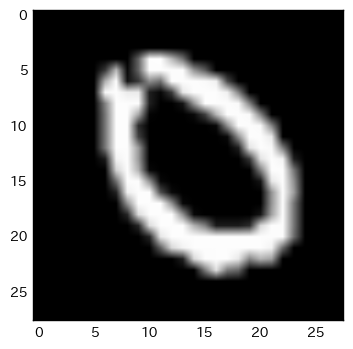

In [20]:
X_check = mnist.data[shuffle_idx[3000:3001]] # 3001番目の画像を指定
y_check = mnist.target[shuffle_idx[3000:3001]]

y_check_predict = estimator.predict(X_check) #これで予測。

plt.imshow(X_check.reshape((28, 28)))
print("{0:1.0f}と予測".format(y_check_predict[0]))
print("答えは{0:1.0f}".format(y_check[0]))

必ずしも正解するとは限りません。では、一体どのくらいの割合で失敗するのでしょうか？

## 訓練集合に含まれていないデータに対するスコア
訓練集合に含まれていないデータに対するスコア（正解率）はどのくらいでしょうか。試みに1000個に対するスコアを見てみましょう。

In [21]:
X_test = mnist.data[shuffle_idx[3000:4000]]
y_test = mnist.target[shuffle_idx[3000:4000]]
accuracy_test = estimator.score(X_test, y_test)

print(accuracy_test * 100,"%")

82.6 %


## このスコアは…高いのか？

およそ5問中1問不正解。これは高いのか低いのか。
例えば、100万通の郵便物を仕分けたとしましょう。郵便番号は7桁だから、700万件判別させることになります。そのうち、140万件ほどミスすることになります。こんなシステムは実用的に使えません。

では実用化できる程度にスコアを上げるにはどうすれば良いでしょうか？